# COMP5318 Assignment 1: Coding Part


## 1. Setup

### 1.1 Hardware and Software Information

Hardware: 
  * MacBook Pro (13-inch, 2017, Four Thunderbolt 3 Ports) 
  * Processor: 3.1 GHz Dual-Core Intel Core i5
  * Memory: 8 GB 2133 MHz LPDDR3
  * Startup Disk: Macintosh HD
  * Graphics: Intel Iris Plus Graphics 650 1536 MB
  
Software:
  *   macOS Big Sur
  *   Anaconda
  *   Python 3.7

### 1.2 Load Data and Import Common Libraries

In [411]:
import h5py
import numpy as np
import os
print(os.listdir("./Input/train"))

['images_training.h5', 'labels_training.h5']


In [412]:
with h5py.File('./Input/train/images_training.h5','r') as H:
    data_train = np.copy(H['datatrain'])
with h5py.File('./Input/train/labels_training.h5','r') as H:
    label_train = np.copy(H['labeltrain'])

# using H['datatest'], H['labeltest'] for test dataset.
with h5py.File('./Input/test/images_testing.h5','r') as H:
    data_test = np.copy(H['datatest'])
with h5py.File('./Input/test/labels_testing_2000.h5','r') as H:
    label_test = np.copy(H['labeltest'])
    
data_test = data_test[:2000,:]

print(data_train.shape, label_train.shape, data_test.shape, label_test.shape) 
#30k 28x28 training images with 30k labels
#5k 28x28 testing images with only 2k true labels available, the other 3k true labels are reserved for marking
#10 classes

(30000, 784) (30000,) (2000, 784) (2000,)


In [413]:
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
import time
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix

### 1.3 Inspect Data

In [414]:
category_dict = {0: 'T-shirt/Top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle Boot'}

In [415]:

# data_train_28by28 = data_train.reshape((data_train.shape[0], 28, 28)) #reshape the training data from 30kx784 to 30kx28x28
# plt.imshow(data_train_28by28[0], cmap=plt.get_cmap('gray'))
# plt.title("class " + str(label_train[0]) + ": " + category_dict[label_train[0]] )
# plt.show()

In [416]:
# # plot the first 15 images
# fig = plt.figure(figsize=(8, 6))
# for i in range(10):
#     ax = fig.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
#     ax.imshow(data_train_28by28[i], cmap=plt.cm.bone)

In [417]:
# for i in label_train[:10]:
#     print(category_dict[i])

In [418]:
# data_test_28by28 = data_test.reshape((data_test.shape[0], 28, 28))
# fig = plt.figure(figsize=(8, 6))
# for i in range(10):
#     ax = fig.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
#     ax.imshow(data_test_28by28[i], cmap=plt.cm.bone)

In [419]:
# for i in label_test[:10]:
#     print(category_dict[i])

## 2. Data Preprocessing

In [420]:
#start timing
start_pre = time.time()

### 2.1: Normalisation (Inspected, no need)

Given data are already scaled within [0,1] so there's no need to do further normalisation.

In [421]:
data_train.min(), data_train.max(), data_test.min(), data_test.max()

(0.0, 1.0, 0.0, 1.0)

### 2.2: Dimension Reduction through PCA

#### 2.2.1 Decide best number of components

The elbow point here looks like n_components = 60 which preserves ~87% variance. However, after some tuning and experimentation, I noticed that the best classifier trained with 0.95% variance/226 components has higher CV accuracy without running overtime. Hence here I chose to keep 0.95% variance/226 components.

In [422]:
#If we reserve 95% variance
pca_95 = PCA(n_components=0.95)
pca_95.fit(data_train) 

PCA(n_components=0.95)

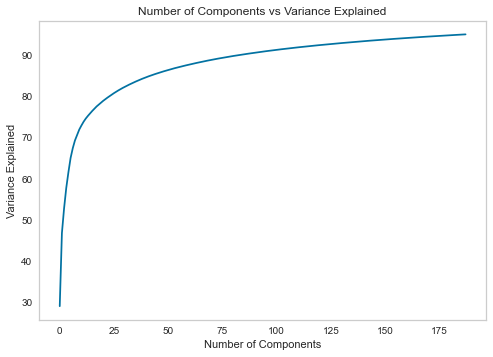

In [423]:
plt.plot(np.cumsum(pca_95.explained_variance_ratio_*100))
plt.title("Number of Components vs Variance Explained")
plt.xlabel("Number of Components")
plt.ylabel("Variance Explained")
plt.grid()

In [424]:
print("Variance$ explained by 20 components: {:.2f}%".format(np.cumsum(pca_95.explained_variance_ratio_*100)[19]))
print("Variance$ explained by 40 components: {:.2f}%".format(np.cumsum(pca_95.explained_variance_ratio_*100)[39]))
print("Variance$ explained by 60 components: {:.2f}%".format(np.cumsum(pca_95.explained_variance_ratio_*100)[59]))
print("Variance$ explained by 80 components: {:.2f}%".format(np.cumsum(pca_95.explained_variance_ratio_*100)[79]))
print("Variance$ explained by 100 components: {:.2f}%".format(np.cumsum(pca_95.explained_variance_ratio_*100)[99]))

Variance$ explained by 20 components: 78.46%
Variance$ explained by 40 components: 84.46%
Variance$ explained by 60 components: 87.61%
Variance$ explained by 80 components: 89.70%
Variance$ explained by 100 components: 91.21%


#### 2.2.2 Apply PCA with selected n_component 
Apply PCA with n_component = 0.95 (aka 228 components) to both training and testing data

In [425]:
# reduced both training and testing data dimension from 784 to 60
data_train_pre.shape, label_train.shape, data_test_pre.shape, label_test.shape

((30000, 188), (30000,), (2000, 188), (2000,))

In [426]:
#apply n_component = 228 or 0.95
pca_95 = PCA(n_components=0.95)
pca_95.fit(data_train) 

#here xxx_pre means preprocessed
data_train_pre = pca_95.transform(data_train) 
data_test_pre = pca_95.transform(data_test) 

In [427]:
#end preprocessing timing
end_pre = time.time()
preprocessing_time = end_pre - start_pre
print("Preprocessing time took {:.2f}s".format(preprocessing_time))

Preprocessing time took 4.35s


## 3. Hyperparameter Tuning

GridSearchCV method in scikit-learn includes hyperparameter tuning as well as model training via cross-validation. In this section, I mainly explored different classifiers with GridSearchCV method and inspected their testing accuracy using their best tuned hyperparameters. In the end, I picked the top-3 classifiers with the best testing accuracy - KNN, SVM and Bagging with SVM.

**Classifier 1 - KNN (selected)**

In [428]:
# #step 1: create parameter grid/parameter combo
# param_grid = {
#     'n_neighbors': [3, 5, 7, 9, 11], 
#     'p': [1, 2], #p=1 manhattan, p=2 Euclidean
#     'weights': ['uniform', 'distance']
# } 
# print("Parameter grid:\n{}".format(param_grid))

# #step 2: split data into training and testing (already did previously)

# #step 3: find the best parameter combo and retrain it over all training data
# #step 3.1: create GridSearchCV object and fit over training data
# # 1. finding best parameters over partial training data 
# # 2. use such best parameters to retrain model over all training data
# grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=10, n_jobs = -1, return_train_score=True)
# grid_search.fit(data_train_pre, label_train)
# #best model using partial training data(training set of cv)
# print("Best parameters: {}".format(grid_search.best_params_))
# print("Best estimator:\n{}".format(grid_search.best_estimator_))
# #best cv accuracy using partial training data(training set of cv)
# print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))
# #step 5: test the retrained classifier performance over test data
# print("Test score: {:.2f}".format(grid_search.score(data_test_pre, label_test)))

**Classifier 2 - SVM (selected)**

In [429]:
# param_grid = {'kernel': ['linear', 'poly', 'rbf'], 
#              'C': [3.15, 3.75, 4.35, 4.95], 
#              'gamma': [0.285, 0.0385, 0.0485, 0.0585] #big gamma doesn't work well;playing around until I get this range
#              }

# #step 3.1: create GridSearchCV object and fit over training data
# # 1. finding best parameters over partial training data 
# # 2. use such best parameters to retrain model over all training data
# grid_search = GridSearchCV(svm.SVC(), param_grid, cv=10, return_train_score=True)
# # grid_search.fit(data_train_pre, label_train)
# grid_search.fit(data_train_pre, label_train)
# #best model using partial training data(training set of cv)
# print("Best parameters: {}".format(grid_search.best_params_))
# print("Best estimator:\n{}".format(grid_search.best_estimator_))
# #best cv accuracy using partial training data(training set of cv)
# print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))
# #step 5: test the retrained classifier performance over test data
# print("Test score: {:.2f}".format(grid_search.score(data_test_pre, label_test)))

**Classifier 3 - Bagging with SVM (selected)**

In [430]:
# param_grid = {'n_estimators' : [15, 20, 25, 30]}

# #step 3.1: create GridSearchCV object and fit over training data
# # 1. finding best parameters over partial training data 
# # 2. use such best parameters to retrain model over all training data
# grid_search = GridSearchCV(
#     BaggingClassifier(svm.SVC(kernel='rbf', C = 3.150, gamma = 0.0385)), 
#     param_grid,
#     cv = 10
# )
# # grid_search.fit(data_train_pre, label_train)
# grid_search.fit(data_train_pre, label_train)
# #best model using partial training data(training set of cv)
# print("Best parameters: {}".format(grid_search.best_params_))
# print("Best estimator:\n{}".format(grid_search.best_estimator_))
# #best cv accuracy using partial training data(training set of cv)
# print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))
# #step 5: test the retrained classifier performance over test data
# print("Test score: {:.2f}".format(grid_search.score(data_test_pre, label_test)))

**Classifier 4 - AdaBoost with Decision Trees**

In [431]:
# param_grid = {'n_estimators':[30, 33, 36, 39], 
#              'learning_rate':[0.5, 0.7]
#              }

# #step 3.1: create GridSearchCV object and fit over training data
# # 1. finding best parameters over partial training data 
# # 2. use such best parameters to retrain model over all training data
# grid_search = GridSearchCV(AdaBoostClassifier(DecisionTreeClassifier(criterion='entropy', max_depth=13, random_state=42)), param_grid, cv=10, return_train_score=True)
# # grid_search.fit(data_train_pre, label_train)
# grid_search.fit(data_train_pre, label_train)
# #best model using partial training data(training set of cv)
# print("Best parameters: {}".format(grid_search.best_params_))
# print("Best estimator:\n{}".format(grid_search.best_estimator_))
# #best cv accuracy using partial training data(training set of cv)
# print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))
# #step 5: test the retrained classifier performance over test data
# print("Test score: {:.2f}".format(grid_search.score(data_test_pre, label_test)))

**Classifier 5 - Bagging with Decision Trees**

In [432]:
# param_grid = {'n_estimators':[15, 20, 25, 30]
#              }

# #step 3.1: create GridSearchCV object and fit over training data
# # 1. finding best parameters over partial training data 
# # 2. use such best parameters to retrain model over all training data
# grid_search = GridSearchCV(BaggingClassifier(DecisionTreeClassifier(criterion='entropy', max_depth=16, random_state=42)), param_grid, cv=10, return_train_score=True)
# # grid_search.fit(data_train_pre, label_train)
# grid_search.fit(data_train_pre, label_train)
# #best model using partial training data(training set of cv)
# print("Best parameters: {}".format(grid_search.best_params_))
# print("Best estimator:\n{}".format(grid_search.best_estimator_))
# #best cv accuracy using partial training data(training set of cv)
# print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))
# #step 5: test the retrained classifier performance over test data
# print("Test score: {:.2f}".format(grid_search.score(data_test_pre, label_test)))

## 4: Implement Classifiers with Best Hyperparameters

### 4.1 Train classifiers with best hyperparameters and obtain training time

**Classifier 1 - KNN**

In [433]:
start_knn = time.time()
knn = KNeighborsClassifier(n_neighbors = 9, p = 1, weights = 'distance')
knn.fit(data_train_pre, label_train)
end_knn = time.time()
knn_time = end_knn-start_knn
print("KNN Algorithms training time {:.2f}s".format(knn_time))

KNN Algorithms training time 0.03s


**Classifier 2 - SVM**

In [434]:
start_svm = time.time()
# svm_clf = svm.SVC(kernel='rbf', C = 10, gamma = 'scale') 
svm_clf = svm.SVC(kernel='rbf', C = 3.150, gamma = 0.0385) 
svm_clf.fit(data_train_pre, label_train)
end_svm = time.time()
svm_time = end_svm-start_svm
print("SVM Algorithms training time {:.2f}s".format(svm_time))

SVM Algorithms training time 48.29s


**Classifier 3 - Bagging with SVM**

In [435]:
start_bagging = time.time()
# bag_clf = BaggingClassifier(svm.SVC(kernel='rbf', C = 10, gamma = 'scale'), n_estimators = 20)
bag_clf = BaggingClassifier(svm.SVC(kernel='rbf', C = 3.150, gamma = 0.0385), n_estimators = 20)
bag_clf.fit(data_train_pre, label_train)
end_bagging = time.time()
bagging_time = end_bagging-start_bagging
print("Bagging Algorithms training time {:.2f}s".format(bagging_time))

Bagging Algorithms training time 428.42s


## 5. Compare classifiers with performance and time metrics

### 5.1 Accuracy and Inference Time

In [436]:
#Training accuracy of KNN
y_pred_train_knn = knn.predict(data_train_pre)

#Inference time of KNN
start_inf_knn = time.time()
y_pred_test_knn = knn.predict(data_test_pre)
end_inf_knn = time.time()
knn_inf_time = end_inf_knn-start_inf_knn
knn_score_train = accuracy_score(label_train, y_pred_train_knn)
knn_score_test = accuracy_score(label_test, y_pred_test_knn)
print("KNN accuracy on training set: {:.3f}".format(knn_score_train))
print("KNN accuracy on test set: {:.3f}".format(knn_score_test))
print("KNN inference time on test set: {:.2f}s".format(knn_inf_time))

KNN accuracy on training set: 1.000
KNN accuracy on test set: 0.840
KNN inference time on test set: 15.51s


In [437]:
#Training accuracy of SVM
y_pred_train_svm = svm_clf.predict(data_train_pre)

#Inference time of SVM
start_inf_svm = time.time()
y_pred_test_svm = svm_clf.predict(data_test_pre)
end_inf_svm = time.time()
svm_inf_time = end_inf_svm-start_inf_svm

svm_score_train = accuracy_score(label_train, y_pred_train_svm)
svm_score_test = accuracy_score(label_test, y_pred_test_svm)
print("SVM accuracy on training set: {:.3f}".format(svm_score_train))
print("SVM accuracy on test set: {:.3f}".format(svm_score_test))
print("SVM inference time on test set: {:.2f}s".format(svm_inf_time))

SVM accuracy on training set: 0.984
SVM accuracy on test set: 0.884
SVM inference time on test set: 7.09s


In [438]:
#Training accuracy of Bagging
y_pred_train_bagging = bag_clf.predict(data_train_pre)

#Inference time of Bagging
start_inf_bagging = time.time()
y_pred_test_bagging = bag_clf.predict(data_test_pre)
end_inf_bagging = time.time()
bagging_inf_time = end_inf_bagging-start_inf_bagging
bagging_score_train = accuracy_score(label_train, y_pred_train_bagging)
bagging_score_test = accuracy_score(label_test, y_pred_test_bagging)
print("Bagging ensemble of SVM - accuracy on training set: {:.2f}".format(bagging_score_train))
print("Bagging ensemble of SVM - accuracy on test set: {:.3f}".format(bagging_score_test))
print("Bagging inference time on test set: {:.2f}s".format(bagging_inf_time))

Bagging ensemble of SVM - accuracy on training set: 0.98
Bagging ensemble of SVM - accuracy on test set: 0.884
Bagging inference time on test set: 89.89s


### 5.2 Confusion Matrix

In [439]:
targets = ['T-shirt/Top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']

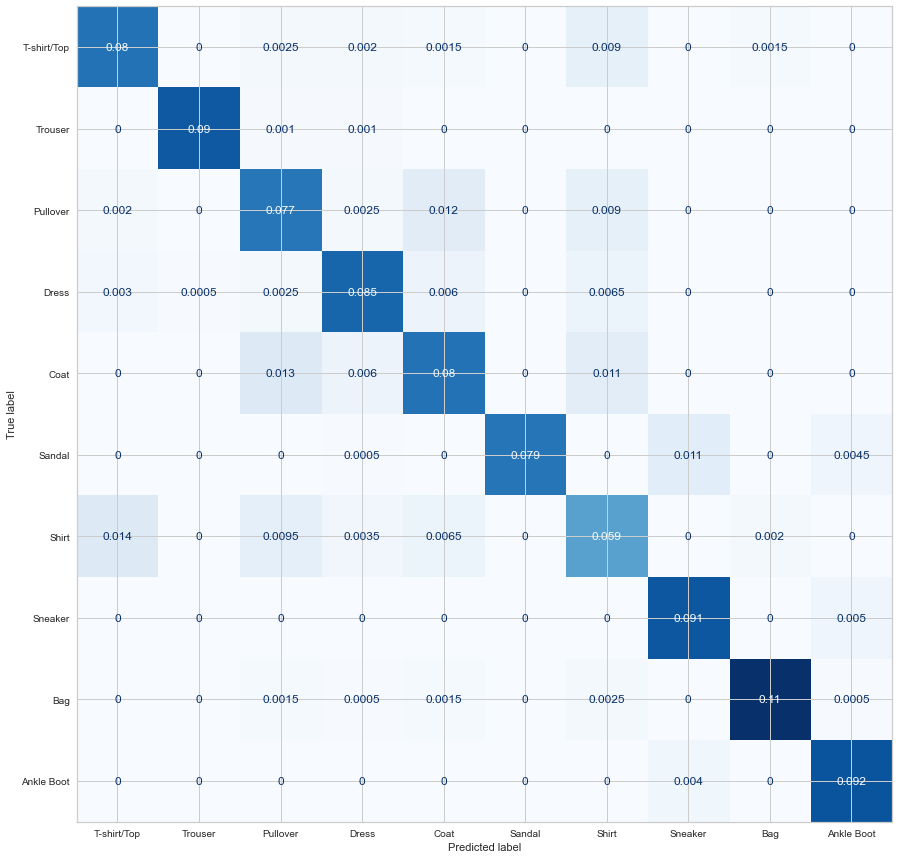

In [440]:
#Confusion Matrix
#KNN
fig, ax = plt.subplots(figsize=(15, 15))
plot_confusion_matrix(knn, data_test_pre, label_test, cmap=plt.cm.Blues, ax=ax, display_labels=targets, normalize = 'all', colorbar = False)  #normalize = 'all' let /all in matrix 
plt.show()  

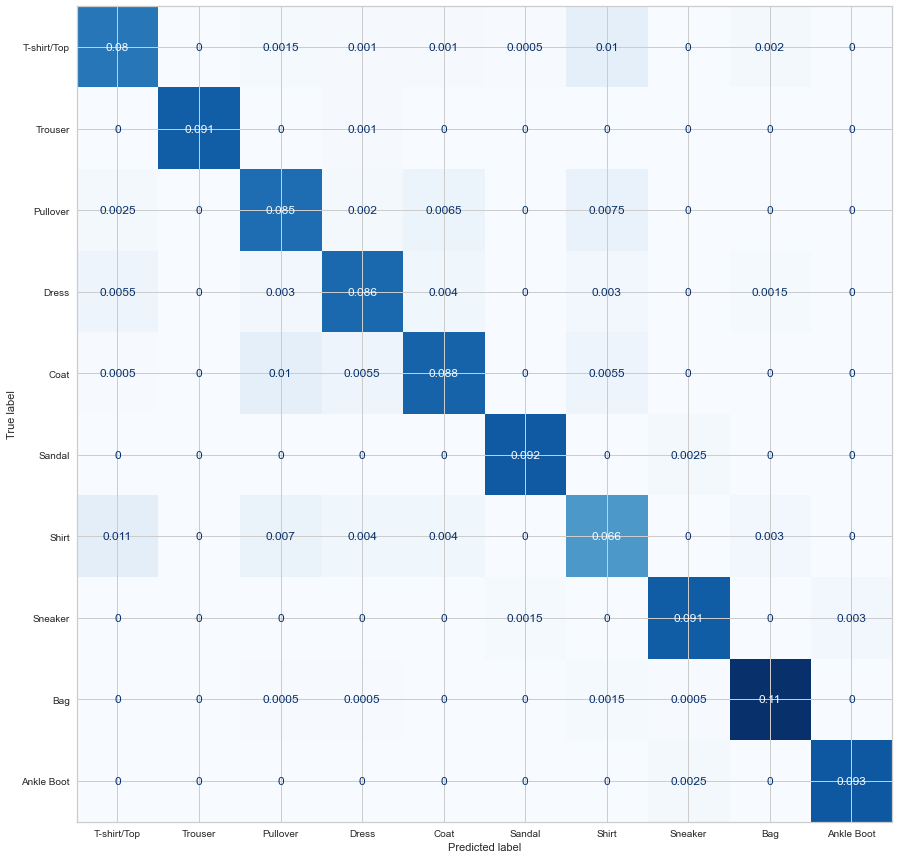

In [441]:
#SVM
fig, ax = plt.subplots(figsize=(15, 15))
plot_confusion_matrix(svm_clf, data_test_pre, label_test, cmap=plt.cm.Blues, ax=ax, display_labels=targets, normalize = 'all', colorbar = False)  
plt.show()  

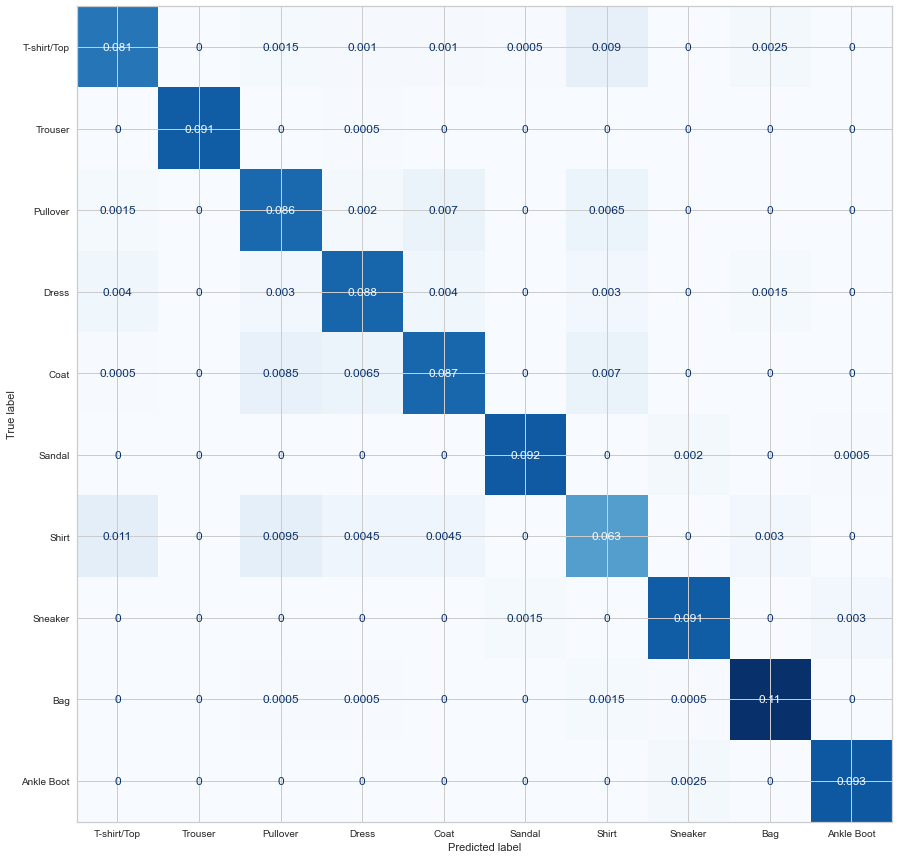

In [442]:
#Bagging 
fig, ax = plt.subplots(figsize=(15, 15))
plot_confusion_matrix(bag_clf, data_test_pre, label_test, cmap=plt.cm.Blues, ax=ax, display_labels=targets, normalize = 'all', colorbar = False)  
plt.show()

### 5.3 Classification Report

In [443]:
# from yellowbrick.classifier import classification_report

In [444]:
# fig, ax = plt.subplots(figsize=(10, 10))
# viz = classification_report(
#     knn, data_train_pre, label_train, data_test_pre, label_test, ax=ax, cmap='GnBu', classes=targets)
# viz.fit(data_train_pre, label_train)
# viz.score(data_test_pre, label_test)
# viz.show()

In [445]:
# #KNN
# print(classification_report(label_test, y_pred_test_knn, target_names=targets))

In [446]:
# fig, ax = plt.subplots(figsize=(10, 10))
# viz = classification_report(
#     svm_clf, data_train_pre, label_train, data_test_pre, label_test, ax=ax, cmap='GnBu', classes=targets)
# viz.fit(data_train_pre, label_train)
# viz.score(data_test_pre, label_test)
# viz.show()

In [447]:
# #SVM
# print(classification_report(label_test, y_pred_test_svm, target_names=targets))  

In [448]:
# fig, ax = plt.subplots(figsize=(10, 10))
# viz = classification_report(
#     bag_clf, data_train_pre, label_train, data_test_pre, label_test, ax=ax, cmap='GnBu', classes=targets)
# viz.fit(data_train_pre, label_train)
# viz.score(data_test_pre, label_test)
# viz.show()

In [449]:
# #BaggingwithSVM
# print(classification_report(label_test, y_pred_test_bagging, target_names=targets))  

### 5.4 Other Visualisations

visualisation for comparing class pixel distributions 

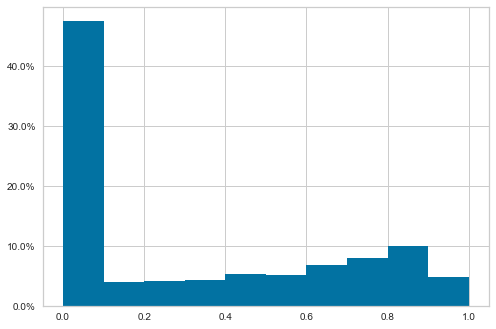

In [450]:
from matplotlib.ticker import PercentFormatter
#find the rows of T-shirt/Top - class 0
shape0 = data_test[np.where(label_test == 0)].shape[0]
class_0 = data_test[np.where(label_test == 0)].reshape((shape0*28*28,1))
plt.hist(class_0, weights=np.ones(len(class_0)) / len(class_0))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

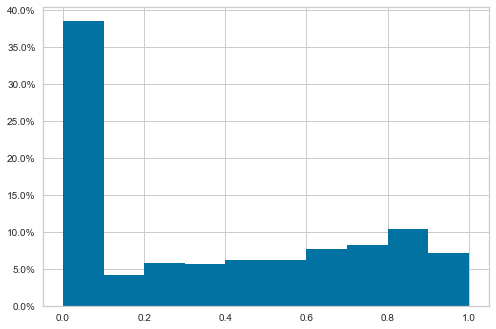

In [451]:
#find the rows of Pullover - class 2
shape0 = data_test[np.where(label_test == 2)].shape[0]
class_2 = data_test[np.where(label_test == 2)].reshape(shape0*28*28,1)
plt.hist(class_2, weights=np.ones(len(class_2)) / len(class_2))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

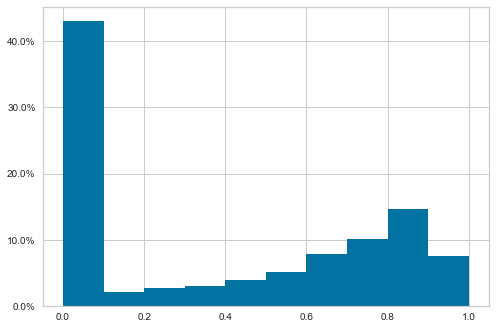

In [452]:
#find the rows of Coat - class 4
shape0 = data_test[np.where(label_test == 4)].shape[0]
class_4 = data_test[np.where(label_test == 4)].reshape(shape0*28*28,1)
plt.hist(class_4, weights=np.ones(len(class_4)) / len(class_4))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

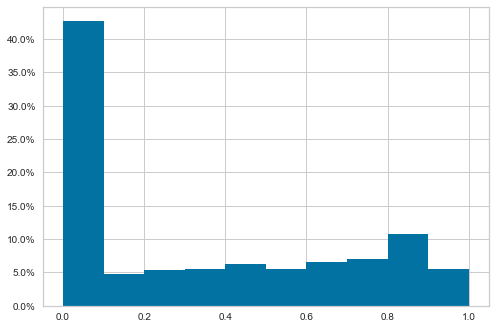

In [453]:
#find the rows of Shirt - class 6
shape0 = data_test[np.where(label_test == 6)].shape[0]
class_6 = data_test[np.where(label_test == 6)].reshape(shape0*28*28,1)
plt.hist(class_6, weights=np.ones(len(class_6)) / len(class_6))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

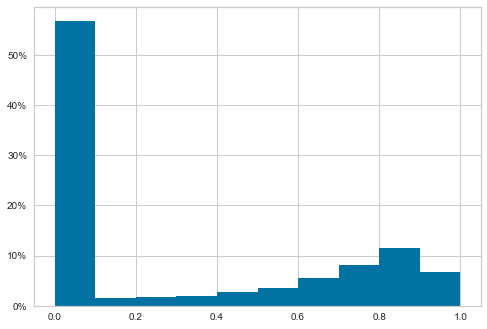

In [454]:
#find the rows of Shirt - class 8
shape0 = data_test[np.where(label_test == 9)].shape[0]
class_9 = data_test[np.where(label_test == 9)].reshape(shape0*28*28,1)
plt.hist(class_9, weights=np.ones(len(class_9)) / len(class_9))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

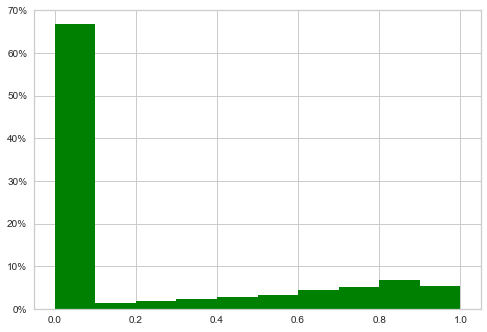

In [455]:
#find the rows of Trousers - class 3
shape0 = data_test[np.where(label_test == 1)].shape[0]
class_1 = data_test[np.where(label_test == 1)].reshape((shape0*28*28,1))
plt.hist(class_1, weights=np.ones(len(class_1)) / len(class_1), color = 'green')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

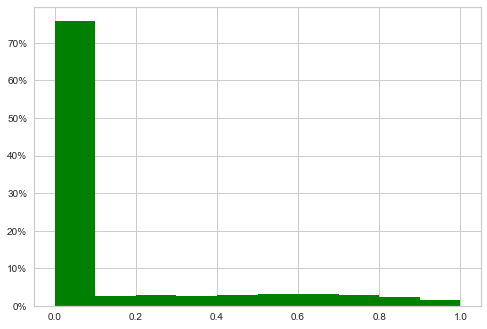

In [456]:
#find the rows of Sandal - class 5
shape0 = data_test[np.where(label_test == 5)].shape[0]
class_5 = data_test[np.where(label_test == 5)].reshape((shape0*28*28,1))
plt.hist(class_5, weights=np.ones(len(class_5)) / len(class_5), color = 'green')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

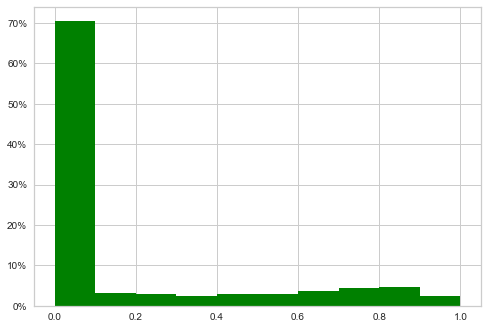

In [457]:
#find the rows of Sneaker - class 7
shape0 = data_test[np.where(label_test == 7)].shape[0]
class_7 = data_test[np.where(label_test == 7)].reshape((shape0*28*28,1))
plt.hist(class_7, weights=np.ones(len(class_7)) / len(class_7), color = 'green')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

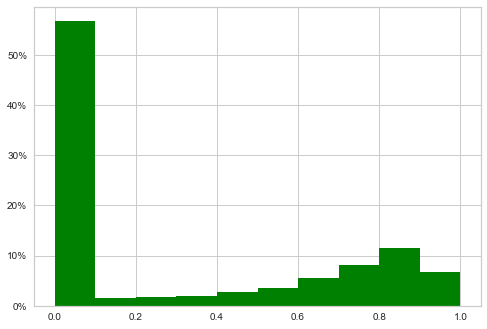

In [458]:
#find the rows of Ankle Boot - class 9
shape0 = data_test[np.where(label_test == 9)].shape[0]
class_9 = data_test[np.where(label_test == 9)].reshape((shape0*28*28,1))
plt.hist(class_9, weights=np.ones(len(class_9)) / len(class_9), color = 'green')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

## 6. Save Output
Save the best classifier - SVM's test set prediction as output and load into h5 file

In [459]:
import numpy as np
output = y_pred_test_svm
with h5py.File('./Output/predicted_labels.h5','w') as H:
    H.create_dataset('Output', data=output)